<a href="https://colab.research.google.com/github/jackliu333/object_detection_using_tensorflow/blob/main/Training_Customised_Image_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Codes adapted from https://github.com/nicknochnack/TFODCourse/blob/main/2.%20Training%20and%20Detection.ipynb
# Images sampled from https://github.com/marcusklasson/GroceryStoreDataset, with bounding boxes drawn manually for each object
# To run using Google Colab; switch runtime type to GPU for speedup
import numpy as np
import random
import tensorflow as tf

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration parameters

Including paths and training hyper-parameters

In [4]:
import os
print(f"Current OS: {os.name}") 

Current OS: nt


In [112]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

# SSD has good tradeoff between speed and accuracy; can switch to other pretrained model
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# TF official script to encode training data to tf record format
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'

# Mapping dictionary between label and integer id
LABEL_MAP_NAME = 'label_map.pbtxt'

TENSORFLOW = '..'

# Define a list of folder paths to be created (if needed) and used later
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    #'IMAGE_SOURCE_PATH':os.path.join('images'),
    'IMAGE_SOURCE_PATH':os.path.join('E:','Users','Vince','Datasets','NZRC','Gordon','CycloneGitaRawImagery','ML4DR_20210910_01'),
    
    # bounding box annotation
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
}

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
# create folder paths if not exist
for p in paths.values():
    if not os.path.exists(p):
        !mkdir -p {p}

# Set up TF model training logistics

### Download TF model training utility scripts from TF model zoo

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'objection_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

### Install TF object detection library

May hit some error during installation, can be ignored, as long as it returns "OK" in the last line.

In [ ]:
#Linux version
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. 
    !cd Tensorflow/models/research && cp object_detection/packages/tf2/setup.py . && python -m pip install . 


#windows version
if os.name =='nt':
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=.
    !cd Tensorflow/models/research && copy object_detection\packages\tf2\setup.py . && python -m pip install .

In [ ]:
# Verify installation
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

In [6]:
# test if TF object detection library could be loaded
import object_detection

### Download and decompress TF pretrained model

In [ ]:
#linux version
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

#Windows version
if os.name =='nt':
    !wget {PRETRAINED_MODEL_URL}
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

### Download training images

In [ ]:
#Not needed
#import shutil

#if os.path.exists('object_detection_using_tensorflow'):
#    shutil.rmtree('object_detection_using_tensorflow')

#!git clone https://github.com/jackliu333/object_detection_using_tensorflow.git

### Create label map

In [11]:
labels = [{'name':'None', 'id':1},
          {'name':'<25%', 'id':2},
          {'name':'>25%', 'id':3},
          {'name':'Abandoned', 'id':4},
          {'name':'Other', 'id':5}]

labels = [{'name':'Apple', 'id':1},
          {'name':'Avocado', 'id':2},
          {'name':'Banana', 'id':3},
          {'name':'Cabbage', 'id':4},
          {'name':'Carrot', 'id':5},
          {'name':'Potato', 'id':6}]


with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### Split into train test folders

In [ ]:
#Create image folders
import shutil

tmp_folders = ['train', 'test']

#windows version
if os.name =='nt':
    for i in tmp_folders:
        if os.path.exists(os.path.join(paths['IMAGE_PATH'], i)):
            shutil.rmtree(os.path.join(paths['IMAGE_PATH'], i))
            !mkdir {os.path.join(paths['IMAGE_PATH'], i)}
        else:
            !mkdir {os.path.join(paths['IMAGE_PATH'], i)}
#Linux
if os.name =='posix':
    for i in tmp_folders:
        if os.path.exists(os.path.join(paths['IMAGE_PATH'], i)):
            shutil.rmtree(os.path.join(paths['IMAGE_PATH'], i))
            !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}
        else:
            !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}

In [19]:
for i in range(len(labels)):
    print("labels[i]['name'] =", labels[i]['name'])
    from_path = os.path.join(paths['IMAGE_SOURCE_PATH'],labels[i]['name'])
    print("from_path =", from_path)
    
    tmp_files = os.listdir(from_path)
    tmp_names = []
    tmp_file_types = []
    for tmp_file in tmp_files:
        tmp_name = os.path.splitext(tmp_file)[0]
        tmp_file_type = os.path.splitext(tmp_file)[1]
        tmp_names.append(tmp_name)
        tmp_file_types.append(tmp_file_type)
        print("   tmp_name =", tmp_name)
        print("   tmp_file_type =", tmp_file_type)


labels[i]['name'] = Apple
from_path = images\Apple
   tmp_name = .DS_Store
   tmp_file_type = 
   tmp_name = Apple_001
   tmp_file_type = .jpg
   tmp_name = Apple_001
   tmp_file_type = .xml
   tmp_name = Apple_002
   tmp_file_type = .jpg
   tmp_name = Apple_002
   tmp_file_type = .xml
   tmp_name = Apple_005
   tmp_file_type = .jpg
   tmp_name = Apple_005
   tmp_file_type = .xml
   tmp_name = Apple_007
   tmp_file_type = .jpg
   tmp_name = Apple_007
   tmp_file_type = .xml
   tmp_name = Apple_015
   tmp_file_type = .jpg
   tmp_name = Apple_015
   tmp_file_type = .xml
   tmp_name = Apple_017
   tmp_file_type = .jpg
   tmp_name = Apple_017
   tmp_file_type = .xml
   tmp_name = Apple_021
   tmp_file_type = .jpg
   tmp_name = Apple_021
   tmp_file_type = .xml
   tmp_name = Apple_022
   tmp_file_type = .jpg
   tmp_name = Apple_022
   tmp_file_type = .xml
   tmp_name = Apple_023
   tmp_file_type = .jpg
   tmp_name = Apple_023
   tmp_file_type = .xml
   tmp_name = Apple_024
   tmp_file_type 

In [ ]:
import shutil

for i in range(len(labels)):
    from_path = os.path.join(paths['IMAGE_SOURCE_PATH'],labels[i]['name'])

    # get unique file names
    tmp_files = os.listdir(from_path)
    tmp_names = []
    tmp_file_types = []
    for tmp_file in tmp_files:
        tmp_name = os.path.splitext(tmp_file)[0]
        tmp_file_type = os.path.splitext(tmp_file)[1]
        tmp_names.append(tmp_name)
        tmp_file_types.append(tmp_file_type)
    tmp_names = list(set(tmp_names))
    tmp_names = [i for i in tmp_names if i != '.DS_Store']
    tmp_file_types = list(set(tmp_file_types))
    tmp_file_types = [i for i in tmp_file_types if len(i) != 0]
    # random shuffle the files
    random.shuffle(tmp_names)
    
    # training and test files
    tmp_names_train = tmp_names[0:int(len(tmp_names)*0.9)]
    tmp_names_test = [i for i in tmp_names if i not in tmp_names_train]

    # move into respective target folders
    for tmp_name in tmp_names_train:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            shutil.copy(os.path.join(from_path, tmp_name_full), \
                        os.path.join(paths['IMAGE_PATH'], "train"))

    for tmp_name in tmp_names_test:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            shutil.copy(os.path.join(from_path, tmp_name_full), \
                        os.path.join(paths['IMAGE_PATH'], "test"))

### Create TF Record from XML files

In [21]:
root_dir = "E:/Users/Vince/Datasets/NZRC/Gordon/CycloneGitaRawImagery"
tfrecords_dir = os.path.join(root_dir, "ML4DR_20210910_01/tfrecords/val2017")
images_dir = os.path.join(root_dir, "ML4DR_20210910_01")
annotations_dir = os.path.join(root_dir, "ML4DR_20210910_01")
annotation_file = os.path.join(annotations_dir, "ML4DR_20210910_01_coco.json")

In [24]:
#Load COCO file information

import json

#Load image refs from COCO file
with open(annotation_file, "r") as f:
    coco_images = json.load(f)["images"]
    
#Load annotations from COCO file
with open(annotation_file, "r") as f:
    coco_annotations = json.load(f)["annotations"]
    
#Load categories from COCO file
with open(annotation_file, "r") as f:
    coco_categories = json.load(f)["categories"]

In [ ]:
#Rearrange COCO file info into a form that can be used to create the TF Record file
# this requires the annotation info for each image be associated to the image info
# and it requires a category dictionary to convert from category_id to category_text

#Work through coco-images
# Extract the image attributes
# For each image get a list of annotations
# Add the annotations list to the image

imageList = []
for image_info in coco_images:
    annotationsList = []
    for annotation in coco_annotations:
        if image_info['id'] == annotation['image_id']:
            annotationsList.append(annotation)
    if len(annotationsList)>0:
        image = image_info
        image['annotations'] = annotationsList
        imageList.append(image)
        
categories = {}
for cat in coco_categories:
    categories[cat['id']] = cat['name']

In [120]:
#This is used when creating the TF Record files
# in the TF Record file
# Store each image with its annotations

from object_detection.utils import dataset_util #, label_map_util
import io
from PIL import Image

def create_tf_example(imageInfo, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(imageInfo['file_name'])), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)

    
    width  = int(imageInfo['width'])
    height = int(imageInfo['height'])

    filename = imageInfo['file_name'].encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for row in imageInfo['annotations']:
        xmins.append(row['bbox'][0] / width)
        xmaxs.append(row['bbox'][1] / width)
        ymins.append(row['bbox'][2] / height)
        ymaxs.append(row['bbox'][3] / height)
        classes_text.append(categories[int(row['category_id'])].encode('utf8'))
        classes.append(int(row['category_id']))

    feature = {
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }
    
    #tf_example = tf.train.Example(feature=feature)
    tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
    return tf_example


In [129]:
output_path = os.path.join(paths['ANNOTATION_PATH'],'test.record')
writer = tf.io.TFRecordWriter(output_path)

for image in imageList:
    tf_example = create_tf_example(image, paths['IMAGE_SOURCE_PATH'])
    writer.write(tf_example.SerializeToString())
    

output_path = os.path.join(paths['ANNOTATION_PATH'],'train.record')
writer = tf.io.TFRecordWriter(output_path)

for image in imageList:
    tf_example = create_tf_example(image, paths['IMAGE_SOURCE_PATH'])
    writer.write(tf_example.SerializeToString())


In [ ]:
# Define TFRecords helper functions
# (See==> from object_detection.utils import dataset_util, label_map_util)
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

#This is used when creating the TF Record files
def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "image_id": int64_feature(example["image_id"]),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        #"image_name": image_feature(example["image_name"]), #My added feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

#This is used read the TF Records
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        #"image_name": tf.io.FixedLenFeature([], tf.string), #My added feature
    }
    print(type(feature_description))
    print(feature_description)
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

### Create TF Record from XML files

In [ ]:
# download conversion script for conversion from XML files to TF Record files
# Note: For this example image files are not added to the TF Record files
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
# Create train data:
!python {os.path.join(paths['SCRIPTS_PATH'],'generate_tfrecord.py')} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {os.path.join(paths['ANNOTATION_PATH'], 'label_map.pbtxt')} -o {os.path.join(paths['ANNOTATION_PATH'],'train.record')}

# Create test data:
!python {os.path.join(paths['SCRIPTS_PATH'],'generate_tfrecord.py')} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {os.path.join(paths['ANNOTATION_PATH'], 'label_map.pbtxt')} -o {os.path.join(paths['ANNOTATION_PATH'],'test.record')}


# Create train data:
#python generate_tfrecord.py -x [PATH_TO_IMAGES_FOLDER]/train -l [PATH_TO_ANNOTATIONS_FOLDER]/label_map.pbtxt -o [PATH_TO_ANNOTATIONS_FOLDER]/train.record

# Create test data:
#python generate_tfrecord.py -x [PATH_TO_IMAGES_FOLDER]/test -l [PATH_TO_ANNOTATIONS_FOLDER]/label_map.pbtxt -o [PATH_TO_ANNOTATIONS_FOLDER]/test.record


# For example
# python generate_tfrecord.py -x C:/Users/sglvladi/Documents/Tensorflow/workspace/training_demo/images/train -l C:/Users/sglvladi/Documents/Tensorflow/workspace/training_demo/annotations/label_map.pbtxt -o C:/Users/sglvladi/Documents/Tensorflow/workspace/training_demo/annotations/train.record
# python generate_tfrecord.py -x C:/Users/sglvladi/Documents/Tensorflow/workspace/training_demo/images/test -l C:/Users/sglvladi/Documents/Tensorflow2/workspace/training_demo/annotations/label_map.pbtxt -o C:/Users/sglvladi/Documents/Tensorflow/workspace/training_demo/annotations/test.record

### Copy model configuration file to training folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {paths['CHECKPOINT_PATH']}
    
if os.name =='nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {paths['CHECKPOINT_PATH']}

### Update configuration file for transfer learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# Read current configuration file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

# Update based on new labels
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

# Write to configuration file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Model training

ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30

In [ ]:
# fix opencv-python version issue 
#!pip uninstall opencv-python-headless 
#!pip install opencv-python-headless==4.1.2.30

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
!{command}

# (Optional) Model evaluation

In [ ]:
# stop evaluation if needed
#command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
#!{command}

# Predicting object category in image

### Load trained model from checkpoint

In [10]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

# @tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### Detect objects in image

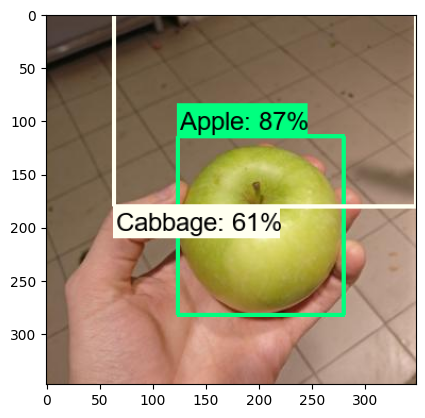

In [12]:
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline

# Randomly select an image to be detected
tmp_img = random.choice([file for file in os.listdir(os.path.join(paths['IMAGE_PATH'], 
                                              'test')) if file.endswith(".jpg")])
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', tmp_img)

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()